# Benchmarking New RAG Approaches with MS MARCO
Author: Tiernan Lindauer, Datastax Inc.

In [5]:
# Some minor setup for the notebook
import warnings
import nest_asyncio

# Ignore all warnings
warnings.filterwarnings("ignore")

# Allows for running async code in Jupyter notebooks
nest_asyncio.apply()

#### Set up your environment variables for running these benchmarks.
Note: You MUST have a `.env` file present!

In [6]:
from dotenv import load_dotenv

assert load_dotenv(override=True)

#### Load the MS MARCO dataset from HuggingFace
We'll get the newest version, but `v1.1` can also work. We'll use just a subset of the full dataset. The dataset is arranged by rows, with each row being an anonymized Bing search query. Each row then contains a list of retrieved documents corresponding to the search query. These can then be loaded and run in a vector database -- and this is exactly what we'll do!

In [7]:
from datasets import load_dataset

ms_marco = load_dataset("microsoft/ms_marco", "v2.1")

ValueError: Invalid pattern: '**' can only be an entire path component

#### Calculate Metrics
When testing different RAG approches, it's important not to just rely on one metric.

This is why the following instructions calculate not only MRR, nDCG, precision, and recall.

In [8]:
import numpy as np
from sklearn.metrics import precision_score, recall_score


def ndcg(retrieved_list, relevant_list, k=None):
    def dcg(scores):
        return sum(score / (i + 1) for i, score in enumerate(scores))

    if k is None:
        k = len(retrieved_list)

    retrieved_scores = [1 if doc in relevant_list else 0 for doc in retrieved_list[:k]]
    ideal_scores = sorted(retrieved_scores, reverse=True)

    dcg_value = dcg(retrieved_scores)
    idcg_value = dcg(ideal_scores)

    return dcg_value / idcg_value if idcg_value > 0 else 0


def mean_reciprocal_rank(retrieved_list, relevant_list):
    ranks = []
    for relevant in relevant_list:
        try:
            rank = retrieved_list.index(relevant) + 1
        except ValueError:
            rank = len(retrieved_list) + 1  # Not found
        ranks.append(rank)
    return 1.0 / min(ranks) if ranks else 0.0


def calculate_ndcg(retrieved_list, relevant_list, k=None):
    def dcg(scores):
        return sum(score / (np.log2(idx + 2)) for idx, score in enumerate(scores))

    if k is None:
        k = len(retrieved_list)

    # Relevance scores for retrieved documents
    retrieved_scores = [1 if doc in relevant_list else 0 for doc in retrieved_list[:k]]
    # Ideal relevance scores
    ideal_scores = sorted(retrieved_scores, reverse=True)

    dcg_value = dcg(retrieved_scores)
    idcg_value = dcg(ideal_scores)

    return dcg_value / idcg_value if idcg_value > 0 else 0


def calculate_precision(retrieved_list, relevant_list):
    y_true = [1 if doc in relevant_list else 0 for doc in retrieved_list]
    y_pred = [1] * len(y_true)  # Assuming all retrieved documents are relevant for calculating precision
    return precision_score(y_true, y_pred, zero_division=0)


def calculate_recall(retrieved_list, relevant_list):
    y_true = [1 if doc in relevant_list else 0 for doc in relevant_list]
    y_pred = [1 if doc in retrieved_list else 0 for doc in relevant_list]
    return recall_score(y_true, y_pred, zero_division=0)


def compute_all_stats(retrieved_list, relevant_list):
    return {
        'MRR': mean_reciprocal_rank(retrieved_list, relevant_list),
        'nDCG': calculate_ndcg(retrieved_list, relevant_list, k=len(relevant_list)),
        'Precision': calculate_precision(retrieved_list, relevant_list),
        'Recall': calculate_recall(retrieved_list, relevant_list),
    }

#### Taking a subset of the dataset
Like I said -- let's take a subset of the whole dataset! The default is 1000. Higher numbers will take longer to run. Lower numbers will be faster, but you could have a more biased result.

In [20]:
subset = ms_marco['train'].select(range(1000))

Here's an example query someone asked:

In [6]:
print(subset[2]['query'])

why did stalin want control of eastern europe


#### Extracting Passages
Now, let's take the passage texts and insert them (in order) into a list.

In [63]:
all_texts = []
all_metadatas = []
i = 0
for row in subset:
    all_texts.extend(row['passages']['passage_text'])
    all_metadatas.extend([{'row_id': i} for _ in row['passages']['is_selected']])
    i += 1


In [47]:
print("Number of texts:", len(all_texts))

Number of texts: 9992

# IMPORTANT: Before you get started...

Instead of running the select loading scripts below, check out the concurrent uploaders (found in separate python files). They will DRAMATICALLY speed up this process. If you don't care about execution speed, then just feel free to run all cells. You will still need to set up the databases/clusters in AstraDB/Pinecone/Weaviate.

Doing it this way means you can also run them all at the same time :)

## Test #1: The Default AstraDB Implementation
We'll first test the standard AstraDB implementation using the Data API.

You'll need to ensure that the collection namespace `plainbenchmarkmarco1000` is created in AstraDB.

In [61]:
from langchain_astradb import AstraDBVectorStore
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document

import os

plainvstore = AstraDBVectorStore(
    embedding = OpenAIEmbeddings(),
    collection_name="plainbenchmarkmarco1000",
    token=os.environ["ASTRA_TOKEN"],
    api_endpoint=os.environ["ASTRA_API_ENDPOINT"],
)

In [64]:
docs = []
for text, metadata in zip(all_texts, all_metadatas):
    docs.append(Document(page_content=text, metadata=metadata))

To load your documents, run the below code. *ONLY DO THIS ONCE!*

In [ ]:
plainvstore.add_documents(docs)

Now, let's test our default ("plain") implementation:

In [67]:
import time
from tqdm import tqdm
plain_retrieved_list = []
plain_relevant_list = []
plain_latencies = []


for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    retriever = plainvstore.as_retriever(search_kwargs={"k": n_results})
    before = time.time()
    raw_results = retriever.invoke(query)
    after = time.time()
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    plain_retrieved_list.append(retrieved_list)
    plain_relevant_list.append(relevant_list)
    plain_latencies.append(after - before)

In [96]:
# calculate stats
plain_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
                  zip(plain_retrieved_list, plain_relevant_list)]
plain_avg_latency = np.mean(plain_latencies)

## Test #2: Pure BM25 Implementation
We'll come back to those results later. Now, let's look at the pure BM25 implementation (a traditional retriever).

In [154]:
from langchain_community.retrievers import BM25Retriever
from langchain_core.documents import Document

In [155]:
# Prepare the documents for BM25
bm25_docs = [Document(page_content=passage) for data in subset for passage in data['passages']['passage_text']]

# Initialize BM25 Retriever
bm25_retriever = BM25Retriever.from_documents(bm25_docs)

BM25 is run locally here. Because of that, we can go directly into testing it!

In [157]:
# Now test BM25
bm25_retrieved_list = []
bm25_relevant_list = []
bm25_latencies = []

for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    before = time.time()
    raw_results = bm25_retriever.invoke(query, k=n_results)
    after = time.time()
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    bm25_retrieved_list.append(retrieved_list)
    bm25_relevant_list.append(relevant_list)
    bm25_latencies.append(after - before)


100%|██████████| 1000/1000 [00:06<00:00, 165.10it/s]


In [158]:
bm25_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
              zip(bm25_retrieved_list, bm25_relevant_list)]
bm25_avg_latency = np.mean(bm25_latencies)

## Test #3: AstraDB + ColBERT

Now let's test using AstraDB with ColBERT. ColBERT is a state-of-the-art retrieval model that uses a BERT-based architecture. It's been shown to be very effective in information retrieval tasks.

In [ ]:
import os
from ragstack_colbert import CassandraDatabase, ColbertEmbeddingModel

keyspace = "benchmarksmarco1000parallel"
database_id = os.getenv("ASTRA_DATABASE_ID")
astra_token = os.getenv("ASTRA_TOKEN")

database = CassandraDatabase.from_astra(
    astra_token=astra_token,
    database_id=database_id,
    keyspace=keyspace
)

embedding_model = ColbertEmbeddingModel()

In [105]:
from ragstack_langchain.colbert import ColbertVectorStore as LangchainColbertVectorStore

lc_vector_store = LangchainColbertVectorStore(
    database=database,
    embedding_model=embedding_model,
)

Upload the texts using the ColBERT vector store to AstraDB. This might take some time.

In [ ]:
# WARNING: THIS WILL BE SLOW. CONSIDER RUNNING THE CONCURRENT VERSION INSTEAD.
lc_vector_store.add_texts(all_texts, metadatas=all_metadatas)

In [49]:
import time
from tqdm import tqdm

Now let's test ColBERT on the 1000 queries!

In [106]:
colbert_retrieved_list = []
colbert_relevant_list = []
colbert_latencies = []
for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    before = time.time()
    raw_results = lc_vector_store.similarity_search(query, k=n_results)
    after = time.time()
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    colbert_retrieved_list.append(retrieved_list)
    colbert_relevant_list.append(relevant_list)
    colbert_latencies.append(after - before)

  0%|          | 0/1000 [00:00<?, ?it/s]


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . )what was the immediate impact of the success of the manhattan project?, 		 True, 		 None
#> Output IDs: torch.Size([17]), tensor([ 101,    1, 1007, 2054, 2001, 1996, 6234, 4254, 1997, 1996, 3112, 1997,
        1996, 7128, 2622, 1029,  102])
#> Output Mask: torch.Size([17]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])



100%|██████████| 1000/1000 [10:21<00:00,  1.61it/s]


In [108]:
# calculate stats
colbert_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
                 zip(colbert_retrieved_list, colbert_relevant_list)]
colbert_avg_latency = np.mean(colbert_latencies)

## Test #4: Pinecone Hybrid Search

Hybrid search uses the more traditional BM25 in addition to vector search. The "alpha" controls the balance between the two, and is initially set to 0.5. It can be slower but also more accurate.

In [163]:
import os
from pinecone import Pinecone, ServerlessSpec
from langchain_community.retrievers import (
    PineconeHybridSearchRetriever,
)

index_name = keyspace

In [164]:
# initialize Pinecone client
pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])

# create the index
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="dotproduct",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

In [165]:
index = pc.Index(index_name)

In [166]:
from langchain_openai import OpenAIEmbeddings

openai_embeddings = OpenAIEmbeddings()

In [167]:
from pinecone_text.sparse import BM25Encoder

# or from pinecone_text.sparse import SpladeEncoder if you wish to work with SPLADE

# use default tf-idf values
bm25_encoder = BM25Encoder().default()

In [168]:
bm25_encoder.fit(all_texts)

cwd = os.getcwd()
bm25_encoder.dump(cwd + "/bm25_encoder.json")

  0%|          | 0/9992 [00:00<?, ?it/s]

In [169]:
pinecone_retriever = PineconeHybridSearchRetriever(
    embeddings=openai_embeddings, sparse_encoder=bm25_encoder, index=index
)

In [ ]:
# WARNING: THIS WILL BE SLOW. CONSIDER RUNNING THE CONCURRENT VERSION INSTEAD.
pinecone_retriever.add_texts(all_texts, metadatas=all_metadatas)

In [170]:
result = pinecone_retriever.invoke("What is the capital of France?", k=5)

In [31]:
print(result[:2])

[
    Document(
        page_content='France has been one of the most dominant agricultural centers of Europe for centuries. That 
gave France an important role in European and, to some extent world, affairs in the pre-industrial age.he major 
agricultural products that place France among the top producers in the world market are sugar beets, wine, milk, 
beef and veal, cereals, and oilseeds.',
        metadata={'row_id': 108.0}
    ),
    Document(
        page_content="The most important crop was wheat. Wheat was used to make flour. The farmers ground the wheat
grains in the seigneur's flour mill. They would pay the seigneur with part of the … flour for the use of his mill. 
France may be a small country in Western Europe, but the impact of French cu…. 2  The Weather in France Though 
France is only the size of Texas, it is situated in an area where weather varies greatly.",
        metadata={'row_id': 108.0}
    )
]

Now, let's evaluate the Pinecone Hybrid Search implementation.

In [171]:
pinecone_retrieved_list = []
pinecone_relevant_list = []
pinecone_latencies = []
for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    before = time.time()
    raw_results = pinecone_retriever.invoke(query, k=n_results)
    after = time.time()
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    pinecone_retrieved_list.append(retrieved_list)
    pinecone_relevant_list.append(relevant_list)
    pinecone_latencies.append(after - before)

100%|██████████| 1000/1000 [03:14<00:00,  5.14it/s]


In [172]:
# calculate stats
pinecone_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
                  zip(pinecone_retrieved_list, pinecone_relevant_list)]
pinecone_avg_latency = np.mean(pinecone_latencies)

## Test #5: Weaviate Hybrid Search

Weaviate implements Hybrid Search in a similar way to Pinecone, so let's test it out.

In [ ]:
import os
import weaviate
from dotenv import load_dotenv

load_dotenv(override=True)

auth_config = weaviate.AuthApiKey(api_key=os.environ['WCS_API_KEY'])
client = weaviate.Client(
    url=os.environ['WCS_URL'],
    auth_client_secret=auth_config,
    additional_headers={
        "X-Openai-Api-Key": os.environ["OPENAI_API_KEY"],
    },
)
embeddings = OpenAIEmbeddings()

In [175]:
from langchain_community.retrievers import (
    WeaviateHybridSearchRetriever,
)


def generate_weaviate_retriever(n_results):
    weaviate_retriever = WeaviateHybridSearchRetriever(
        client=client,
        index_name="LangChain",
        text_key="text",
        create_schema_if_missing=True,
        k=n_results
    )
    return weaviate_retriever

In [ ]:
all_texts = []
all_metadatas = []
i = 0
for row in subset:
    all_texts.extend(row['passages']['passage_text'])
    all_metadatas.extend([{'row_id': i} for _ in row['passages']['is_selected']])
    i += 1

docs = []
for text, metadata in zip(all_texts, all_metadatas):
    docs.append(Document(
        metadata=metadata,
        page_content=text
    ))

generate_weaviate_retriever(5).add_documents(docs)  # Value for the number of docs in this doesn't matter

In [176]:
# Let's try an example:
print(generate_weaviate_retriever(5).invoke("What is the capital of France?"))

[Document(page_content='One-third of France’s land is crop growing. Wheat is the major single crop grown at large farms in the Paris Basin and in the north.In southern France, most of the grapes produced are used in making wine being of high quality that come from several regions.In the Mediterranean region, grapes are used for cheaper wines.heat is the major single crop grown at large farms in the Paris Basin and in the north. In southern France, most of the grapes produced are used in making wine being of high quality that come from several regions.'), Document(page_content='France has been one of the most dominant agricultural centers of Europe for centuries. That gave France an important role in European and, to some extent world, affairs in the pre-industrial age.he major agricultural products that place France among the top producers in the world market are sugar beets, wine, milk, beef and veal, cereals, and oilseeds.'), Document(page_content='Food of France-a regional guide. Yo

Now, let's run the 1000 queries once again using Weaviate Hybrid Search.

In [177]:
weaviate_retrieved_list = []
weaviate_relevant_list = []
weaviate_latencies = []

for row in tqdm(subset):
    query = row['query']
    n_results = len(row['passages']['is_selected'])
    weaviate_retriever = generate_weaviate_retriever(n_results)
    success = False
    while not success:
        try:
            before = time.time()
            raw_results = weaviate_retriever.invoke(query)
            after = time.time()
            success = True
        except Exception as e:
            print(e)
    retrieved_list = [result.page_content for result in raw_results]
    relevant_list = row['passages']['passage_text']

    weaviate_retrieved_list.append(retrieved_list)
    weaviate_relevant_list.append(relevant_list)
    weaviate_latencies.append(after - before)

100%|██████████| 1000/1000 [11:09<00:00,  1.49it/s]


In [178]:
# calculate stats
weaviate_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in
                  zip(weaviate_retrieved_list, weaviate_relevant_list)]

weaviate_avg_latency = np.mean(weaviate_latencies)

## Where We Are So Far
Let's use `rich` to print a table for all of these different RAG approaches using the MS MARCO dataset. We'll also display the latencies for these, though note that the BM25 values should be much less than typical (because it's being done locally) and the ColBERT values should be higher (because there is much more computation being done locally + API calls)

In [180]:
# Print a table
from rich.table import Table
from rich.console import Console

metrics = ["Metric"] + list(colbert_stats[0].keys()) + ["Average Latency"]

plain_values = ["Plain"] + [f"{np.mean([stats[metric] for stats in plain_stats]):.4f}" for metric in
                            plain_stats[0].keys()] + [f"{plain_avg_latency:.4f}"]
colbert_values = ["ColBERT"] + [f"{np.mean([stats[metric] for stats in colbert_stats]):.4f}" for metric in
                                colbert_stats[0].keys()] + [f"{colbert_avg_latency:.4f}"]
bm25_values = ["BM25"] + [f"{np.mean([stats[metric] for stats in bm25_stats]):.4f}" for metric in
                          bm25_stats[0].keys()] + [f"{bm25_avg_latency:.4f}"]
pinecone_values = ["Pinecone"] + [f"{np.mean([stats[metric] for stats in pinecone_stats]):.4f}" for metric in
                                  pinecone_stats[0].keys()] + [f"{pinecone_avg_latency:.4f}"]
weaviate_values = ["Weaviate"] + [f"{np.mean([stats[metric] for stats in weaviate_stats]):.4f}" for metric in
                                  weaviate_stats[0].keys()] + [f"{weaviate_avg_latency:.4f}"]

# Create new table with transposed structure
table = Table(title="Metric Comparison:\nColBERT vs. BM25 vs. Pinecone Hybrid vs. Weaviate Hybrid")

# Adding columns
for col in metrics:
    table.add_column(col)

# Adding rows
table.add_row(*plain_values)
table.add_row(*colbert_values)
table.add_row(*bm25_values)
table.add_row(*pinecone_values)
table.add_row(*weaviate_values)


console = Console()
console.print(table)

print("Note: the ColBERT # of candidates was set to half the length of the query embedding.")

                         Metric Comparison:                          
      ColBERT vs. BM25 vs. Pinecone Hybrid vs. Weaviate Hybrid       
┏━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric   ┃ MRR    ┃ nDCG   ┃ Precision ┃ Recall ┃ Average Latency ┃
┡━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Plain    │ 0.9890 │ 0.9826 │ 0.8363    │ 0.8349 │ 0.2462          │
│ ColBERT  │ 0.9825 │ 0.9699 │ 0.7043    │ 0.7024 │ 0.6212          │
│ BM25     │ 0.7442 │ 0.7141 │ 0.5220    │ 0.2086 │ 0.0060          │
│ Pinecone │ 0.9825 │ 0.9816 │ 0.9390    │ 0.3769 │ 0.1928          │
│ Weaviate │ 0.9805 │ 0.9775 │ 0.8120    │ 0.8108 │ 0.5283          │
└──────────┴────────┴────────┴───────────┴────────┴─────────────────┘

Note: the ColBERT # of candidates was set to half the length of the query embedding.


Text(0.5, 1.0, 'Latency Distribution for ColBERT, BM25,\nPinecone Hybrid, and Weaviate Hybrid Searches')

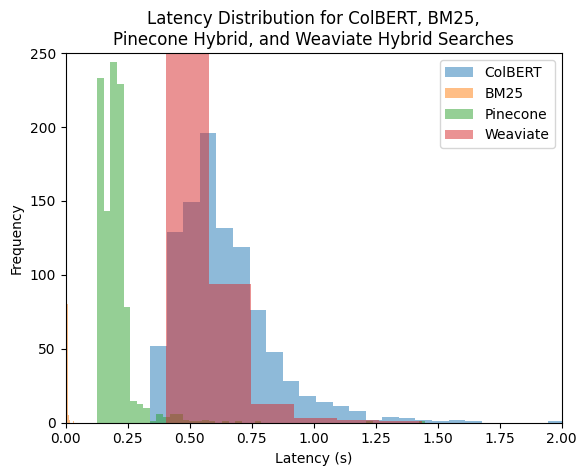

In [88]:
# Plot the latency distribution
import matplotlib.pyplot as plt

plt.hist(colbert_latencies, bins=50, alpha=0.5, label='ColBERT')
plt.hist(bm25_latencies, bins=50, alpha=0.5, label='BM25')
plt.hist(pinecone_latencies, bins=50, alpha=0.5, label='Pinecone')
plt.hist(weaviate_latencies, bins=50, alpha=0.5, label='Weaviate')
plt.legend(loc='upper right')
plt.xlabel('Latency (s)')
plt.ylabel('Frequency')
plt.xlim([0, 2])
plt.ylim([0, 250])
plt.title('Latency Distribution for ColBERT, BM25,\nPinecone Hybrid, and Weaviate Hybrid Searches')

Optional script to save values if the Jupyter server crashes/computer is shut down.

In [140]:
# Save the stats to a json file
import json

cwd = os.getcwd()

with open(f"{cwd}/testing_stats.json", "w") as f:
    json.dump({"ColBERT": colbert_stats, "BM25": bm25_stats, "Pinecone": pinecone_stats, "Weaviate": weaviate_stats, "Plain": plain_stats, "Latencies": {
        "ColBERT": colbert_latencies,
        "BM25": bm25_latencies,
        "Pinecone": pinecone_latencies,
        "Weaviate": weaviate_latencies,
        "Plain": plain_latencies,
    }}, f)

print("Stats saved to testing_stats.json")

Stats saved to testing_stats.json

In [1]:
# Load the stats from the json file
import json
import os

cwd = os.getcwd()
with open(f"{cwd}/testing_stats.json", "r") as f:
    stats = json.load(f)

In [2]:
plain_stats = stats['Plain']
colbert_stats = stats["ColBERT"]
bm25_stats = stats["BM25"]
pinecone_stats = stats["Pinecone"]
weaviate_stats = stats["Weaviate"]

plain_latencies = stats['Latencies']['Plain']
colbert_latencies = stats['Latencies']['ColBERT']
pinecone_latencies = stats['Latencies']['Pinecone']
weaviate_latencies = stats['Latencies']['Weaviate']
bm25_latencies = stats['Latencies']['BM25']

dict_keys(['ColBERT', 'BM25', 'Pinecone', 'Weaviate'])


## Test #6: Altering Colbert Candidates



In [21]:
import sys

sys.path.append(os.path.abspath('ragstack-ai-colbert-pre-score/libs/colbert'))

# The following lines might appear as an error in your IDE, but they should run correctly.
from ragstack_colbert_2.colbert_retriever import ColbertRetriever as ColbertRetriever2
from ragstack_colbert_2.colbert_embedding_model import ColbertEmbeddingModel as ColbertEmbeddingModel2
from ragstack_colbert_2 import CassandraDatabase as CassandraDatabase2

In [22]:
new_database = CassandraDatabase2.from_astra(
    astra_token=astra_token,
    database_id=database_id,
    keyspace=keyspace
)

embedding_model = ColbertEmbeddingModel()

In [23]:
new_colbert_retriever = ColbertRetriever2(
    database=new_database,
    embedding_model=ColbertEmbeddingModel2(),
)

In [24]:
new_colbert_retriever.text_search("What is France known for?", k=5)


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . What is France known for?, 		 True, 		 None
#> Output IDs: torch.Size([9]), tensor([ 101,    1, 2054, 2003, 2605, 2124, 2005, 1029,  102])
#> Output Mask: torch.Size([9]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1])



[(Chunk(doc_id='6f9508ec-3db0-48aa-909e-9a21551b9566', chunk_id=18, text='Our calendars. 1  FestivalsExplore the many festivals that Montral is known for. 2  Accs Culture networkDiscover shows and exhibitions presented by Montrals municipal arts and culture network. 3  Major sporting events (in French)Every year, Montral hosts a number of major sporting events!', metadata={'row_id': '17.0'}, embedding=None),
  5.309963345527649),
 (Chunk(doc_id='67b09287-c902-4d5c-8472-0b0b2f892dce', chunk_id=1, text='France has been one of the most dominant agricultural centers of Europe for centuries. That gave France an important role in European and, to some extent world, affairs in the pre-industrial age.he major agricultural products that place France among the top producers in the world market are sugar beets, wine, milk, beef and veal, cereals, and oilseeds.', metadata={'row_id': '108.0'}, embedding=None),
  5.052829682826996),
 (Chunk(doc_id='67b09287-c902-4d5c-8472-0b0b2f892dce', chunk_id=2, 

In [27]:
from tqdm import tqdm
import time
def test_colbert_at(multiplier):
    colbert_new_retrieved_list = []
    colbert_new_relevant_list = []
    colbert_new_latencies = []
    
    for row in tqdm(subset):
        query = row['query']
        n_results = len(row['passages']['is_selected'])
        before = time.time()
        raw_results = new_colbert_retriever.text_search(query, k=n_results, multiplier=multiplier)
        after = time.time()
        retrieved_list = [result[0].text for result in raw_results]
        relevant_list = row['passages']['passage_text']
    
        colbert_new_retrieved_list.append(retrieved_list)
        colbert_new_relevant_list.append(relevant_list)
        colbert_new_latencies.append(after - before)
        
    # calculate stats
    colbert_new_stats = [compute_all_stats(retrieved_list, relevant_list) for retrieved_list, relevant_list in zip(colbert_new_retrieved_list, colbert_new_relevant_list)]
    colbert_new_avg_latency = np.mean(colbert_new_latencies)
    
    return colbert_new_stats, colbert_new_avg_latency
    

In [ ]:
stat_dict = {}

In [140]:
for multiplier in [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]:
    print(f"Testing multiplier {multiplier}")
    completed = False
    while not completed:
        try:
            stats, avg_latency = test_colbert_at(multiplier)
            stat_dict[multiplier] = {metric: np.mean([stat[metric] for stat in stats]) for metric in stats[0].keys()}
            stat_dict[multiplier]["Average Latency"] = avg_latency
            completed = True
        except Exception as e:
            print(e)

    
print(stat_dict)

Testing multiplier 0.5


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


Testing multiplier 1


100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


Testing multiplier 1.5


 31%|███       | 311/1000 [02:17<05:14,  2.19it/s]ERROR:root:Issue on database.get_chunk_embeddings(): errors={'b83877d6-20f6-4695-a216-b2d1931f8540-us-east-2.db.astra.datastax.com:29042:190dafab-6970-3a67-a21c-1226360de7dc': 'Client request timeout. See Session.execute[_async](timeout)'}, last_host=b83877d6-20f6-4695-a216-b2d1931f8540-us-east-2.db.astra.datastax.com:29042:190dafab-6970-3a67-a21c-1226360de7dc at 	File: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/tasks.py Line: 316
	File: /Users/tiernan.lindauer/PycharmProjects/benchmark-v2/ragstack-ai-colbert-pre-score/libs/colbert/ragstack_colbert_2/cassandra_database.py Line: 216
	File: /Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/cassio/table/mixins/clustered.py Line: 210
	File: /Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/cassio/table/base_table.py Line: 618
	File: /Users/tiernan.lindauer/PycharmProjects/benchmark-v2/

'OperationTimedOut' object has no attribute 'embedding'


 24%|██▍       | 244/1000 [02:49<05:13,  2.41it/s] WARNING:cassandra.connection:Heartbeat failed for connection (19560112176) to b83877d6-20f6-4695-a216-b2d1931f8540-us-east-2.db.astra.datastax.com:29042:190dafab-6970-3a67-a21c-1226360de7dc
ERROR:root:Issue on database.get_relevant_chunks(): ('Unable to complete the operation against any hosts', {<Host: b83877d6-20f6-4695-a216-b2d1931f8540-us-east-2.db.astra.datastax.com:29042:9e3a5bee-3d95-3bf7-90f5-09bd2177324b us-east-2>: ConnectionShutdown('Connection to b83877d6-20f6-4695-a216-b2d1931f8540-us-east-2.db.astra.datastax.com:29042:9e3a5bee-3d95-3bf7-90f5-09bd2177324b was closed'), <Host: b83877d6-20f6-4695-a216-b2d1931f8540-us-east-2.db.astra.datastax.com:29042:00958fd0-af98-391f-9f51-7e3fe763da5c us-east-2>: ConnectionException('Pool is shutdown'), <Host: b83877d6-20f6-4695-a216-b2d1931f8540-us-east-2.db.astra.datastax.com:29042:0669df0f-031f-383e-b452-67a9679bbc6a us-east-2>: ConnectionException('Host has been marked down or removed

'NoHostAvailable' object has no attribute 'embedding'


  0%|          | 0/1000 [00:00<?, ?it/s]ERROR:root:Issue on database.get_relevant_chunks(): ('Unable to complete the operation against any hosts', {}) at 	File: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/tasks.py Line: 316
	File: /Users/tiernan.lindauer/PycharmProjects/benchmark-v2/ragstack-ai-colbert-pre-score/libs/colbert/ragstack_colbert_2/cassandra_database.py Line: 196
	File: /Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/cassio/table/mixins/vector.py Line: 154
	File: /Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/cassio/table/base_table.py Line: 618
	File: /Users/tiernan.lindauer/PycharmProjects/benchmark-v2/.venv/lib/python3.12/site-packages/cassio/table/utils.py Line: 21
	File: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/futures.py Line: 287
	File: /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/asyncio/tasks.py Line: 3

Testing multiplier 2


100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Testing multiplier 2.5


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


Testing multiplier 3


100%|██████████| 1000/1000 [07:19<00:00,  2.27it/s]


Testing multiplier 3.5


100%|██████████| 1000/1000 [07:09<00:00,  2.33it/s]


Testing multiplier 4


100%|██████████| 1000/1000 [07:05<00:00,  2.35it/s]


{0.1: {'MRR': 0.9807643939393941, 'nDCG': 0.9703381788253324, 'Precision': 0.6529484126984128, 'Recall': 0.6452623015873017, 'Average Latency': 0.43634023594856264}, 0.25: {'MRR': 0.9807643939393941, 'nDCG': 0.9703054920808931, 'Precision': 0.652231746031746, 'Recall': 0.6445623015873015, 'Average Latency': 0.4458913817405701}, 0.5: {'MRR': 0.9807643939393941, 'nDCG': 0.9702790161180085, 'Precision': 0.651931746031746, 'Recall': 0.6447623015873016, 'Average Latency': 0.42448836398124695}, 1: {'MRR': 0.9807643939393941, 'nDCG': 0.970331814350477, 'Precision': 0.6528484126984127, 'Recall': 0.6451623015873015, 'Average Latency': 0.4318168184757233}, 2: {'MRR': 0.9807643939393941, 'nDCG': 0.9703730632100548, 'Precision': 0.6529650793650793, 'Recall': 0.6453623015873016, 'Average Latency': 0.4228430716991425}, 3: {'MRR': 0.9807643939393941, 'nDCG': 0.9706089486630909, 'Precision': 0.6532039682539682, 'Recall': 0.6452623015873017, 'Average Latency': 0.4392916903495789}, 4: {'MRR': 0.98076439

In [80]:
colbert_avg_latency = 0.6468
bm25_avg_latency = 0.0062
pinecone_avg_latency = 0.2031
weaviate_avg_latency = 0.5371

In [95]:
print(bm25_stats)

[{'accuracy': 0.78, 'precision': 0.73, 'recall': 0.75}, {'accuracy': 0.79, 'precision': 0.74, 'recall': 0.76}]


In [ ]:
from rich.table import Table
from rich.console import Console

# Create new table with transposed structure
table = Table(title="Vector Search Metric Comparison")

plain_values = ["Default RAGstack"] + [f"{np.mean([stats[metric] for stats in plain_stats]):.4f}" for metric in plain_stats[0].keys()] + [f"{plain_avg_latency:.4f}"]
colbert_values = ["ColBERT (default)"] + [f"{np.mean([stats[metric] for stats in colbert_stats]):.4f}" for metric in colbert_stats[0].keys()] + [f"{colbert_avg_latency:.4f}"]

table.add_column("Metric")
for metric in list(plain_stats[0].keys()) + ["Latency"]:
    table.add_column(metric)

table.add_row(*plain_values)
table.add_row(*colbert_values)
for multiplier, stats in stat_dict.items():
    values = [f"ColBERT (x{multiplier})"] + [f"{value:.4f}" for value in stats.values()]
    table.add_row(*values)
    

console = Console()
console.print(table)

In [ ]:
# Create a plot for metrics vs. candidate multiplier
import matplotlib.pyplot as plt

multipliers = list(stat_dict.keys())
metrics = list(stat_dict[1].keys())

# Remove Average Latency from metrics
metrics.remove("Average Latency")

for metric in metrics:
    values = [stat_dict[multiplier][metric] for multiplier in multipliers]
    plt.plot(multipliers, values, 'x-', label=metric)
    
plt.xlabel('Candidate Multiplier')
plt.ylabel('Metric Value')
plt.title('Metric vs. ColBERT Candidate Multiplier')
plt.legend()

In [ ]:
# Plot the Latency vs Candidate Multiplier
latencies = [stat_dict[multiplier]["Average Latency"] for multiplier in multipliers]
# sort (multipliers, latencies) by multipliers
multipliers, latencies = zip(*sorted(zip(multipliers, latencies)))
plt.plot(multipliers, latencies, 'x-')
plt.xlabel('Candidate Multiplier')
plt.ylabel('Average Latency (s)')
plt.title('Latency vs. ColBERT Candidate Multiplier')

## Testing Metric Computations

In [152]:
# Example data for testing
retrieved_list = ['doc1', 'doc2', 'doc3', 'doc4', 'doc5']
relevant_list = ['doc1', 'doc3', 'doc5', 'doc7']

# Expected results for manual verification
expected_mrr = 1.0 / min([1, 3, 5, 6])
retrieved_scores = [1 if doc in relevant_list else 0 for doc in retrieved_list[:5]]
ideal_scores = sorted(retrieved_scores, reverse=True)

def dcg(scores):
    return sum(score / (np.log2(idx + 2)) for idx, score in enumerate(scores))

dcg_value = dcg(retrieved_scores)
idcg_value = dcg(ideal_scores)
expected_ndcg = dcg_value / idcg_value if idcg_value > 0 else 0

y_true_precision = [1 if doc in relevant_list else 0 for doc in retrieved_list]
y_pred_precision = [1] * len(y_true_precision)
expected_precision = precision_score(y_true_precision, y_pred_precision, zero_division=0)

y_true_recall = [1 if doc in relevant_list else 0 for doc in relevant_list]
y_pred_recall = [1 if doc in retrieved_list else 0 for doc in relevant_list]
expected_recall = recall_score(y_true_recall, y_pred_recall, zero_division=0)

expected_stats = {
    'MRR': expected_mrr,
    'nDCG': expected_ndcg,
    'Precision': expected_precision,
    'Recall': expected_recall,
}

# Run tests
print("Testing nDCG...")
result = ndcg(retrieved_list, relevant_list, k=5)
if np.isclose(result, expected_ndcg, atol=1e-4):
    print("nDCG test passed")
else:
    print(f"nDCG test failed: expected {expected_ndcg}, got {result}")

print("Testing mean reciprocal rank...")
result = mean_reciprocal_rank(retrieved_list, relevant_list)
if np.isclose(result, expected_mrr, atol=1e-4):
    print("Mean Reciprocal Rank test passed")
else:
    print(f"Mean Reciprocal Rank test failed: expected {expected_mrr}, got {result}")

print("Testing alternative nDCG calculation...")
result = calculate_ndcg(retrieved_list, relevant_list, k=5)
if np.isclose(result, expected_ndcg, atol=1e-4):
    print("Alternative nDCG calculation test passed")
else:
    print(f"Alternative nDCG calculation test failed: expected {expected_ndcg}, got {result}")

print("Testing precision calculation...")
result = calculate_precision(retrieved_list, relevant_list)
if np.isclose(result, expected_precision, atol=1e-4):
    print("Precision calculation test passed")
else:
    print(f"Precision calculation test failed: expected {expected_precision}, got {result}")

print("Testing recall calculation...")
result = calculate_recall(retrieved_list, relevant_list)
if np.isclose(result, expected_recall, atol=1e-4):
    print("Recall calculation test passed")
else:
    print(f"Recall calculation test failed: expected {expected_recall}, got {result}")

Testing nDCG...
nDCG test passed
Testing mean reciprocal rank...
Mean Reciprocal Rank test passed
Testing alternative nDCG calculation...
Alternative nDCG calculation test passed
Testing precision calculation...
Precision calculation test passed
Testing recall calculation...
Recall calculation test passed
